
# Gold Price Forecasting 
**Owner:** Senior DS (role‑play) @ OpenAI × Intern (you)  
**Target:** Accuracy > 90% (by MAPE accuracy = `100 * (1 - MAPE)` ) on backtests, plus a 6‑month ahead forecast with visuals.

> ⚠️ Financial time series are noisy and non‑stationary. A hard **90%+ accuracy** target (on genuinely out‑of‑sample horizons) may be unrealistic. This notebook **aims** for it with strong practices (leakage‑safe backtests, walk‑forward CV, careful features) and reports the real metrics transparently.



## What you'll get
- Clean, reproducible **time‑series ML** pipeline (scikit‑learn API).
- **Feature engineering**: lags, rolling stats, RSI, MACD, %B (Bollinger), EMAs, momentum.
- **Walk‑forward CV** (expanding window) to estimate true generalization.
- **Model zoo**: XGBoost (primary), LightGBM (optional), with Optuna tuning.
- **Metrics**: MAE, RMSE, R², **MAPE** and **Accuracy = 100 × (1 − MAPE)**.
- **Plots**: 
  - Train/valid/test split & predictions overlay
  - Residuals (time + histogram)
  - Prediction vs Actual (1:1 line)
  - Feature importance
  - 6‑month forecast with residual‑bootstrap intervals
- **Artifacts** saved to `./artifacts/` (PNGs + CSVs).



## Quick start
1. Run the **Setup** cell to install packages (first run only).
2. Run all cells.  
3. See results in the `artifacts/` folder and the summary at the end.


In [ ]:

import os, warnings, math, json, random, datetime as dt
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED)

ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts will be written to:", os.path.abspath(ARTIFACT_DIR))


Artifacts will be written to: c:\othai\ML_LSDM\XG_Boost\artifacts


## Config & Data Download

In [ ]:

import yfinance as yf

# --- Config ---
TICKER = "GC=F"                 # Gold Futures 
DATE_START = "2024-01-01"
DATE_END   = "2025-08-31"       # None = today


EXOG_TICKERS = {
    "DXY": "DX-Y.NYB",     # US Dollar Index (ICE)
    "WTI": "CL=F",         # WTI Crude
    "SP500": "^GSPC",      # S&P 500
    "US10Y": "^TNX",       # 10Y Treasury yield (in %)
    "BTC": "BTC-USD",      # Bitcoin (for curiosity)
}

# Frequency to model on: 'D' (daily) or 'W'/'M' (weekly/monthly). Monthly often yields lower MAPE.
FREQ = "D"

print(f"Downloading {TICKER} ...")
df = yf.download(TICKER, start=DATE_START, end=DATE_END, progress=False)
if df.empty:
    raise RuntimeError("No data returned. Check ticker or internet access.")

df = df[['Close']].rename(columns={'Close': 'gold_close'}).dropna()
df.index = pd.to_datetime(df.index)
df = df.asfreq('B').ffill().resample(FREQ).last().dropna()
if FREQ in ("W","M"):
    df = df.resample(FREQ).last().dropna()


# exogenous
exo = {}
for name, tk in EXOG_TICKERS.items():
    try:
        tmp = yf.download(tk, start=df.index.min(), end=df.index.max(), progress=False)[['Close']].rename(columns={'Close': name})
        tmp.index = pd.to_datetime(tmp.index)
        tmp = tmp.asfreq('B').ffill().resample(FREQ).last().dropna()
        exo[name] = tmp
    except Exception as e:
        print(f"[WARN] {name}: {e}")

data = df.copy()
for name, tmp in exo.items():
    data = data.join(tmp, how='left')
data = data.ffill().dropna()
print("Data shape:", data.shape)
data.tail()


Data shape: (434, 6)


Price,gold_close,DXY,WTI,SP500,US10Y,BTC
Ticker,GC=F,DX-Y.NYB,CL=F,^GSPC,^TNX,BTC-USD
Date,,,,,,
2025-08-25,3373.800049,98.430000,64.800003,6439.319824,4.275,110124.351562
2025-08-26,3388.600098,98.230003,63.250000,6465.939941,4.258,111802.656250
2025-08-27,3404.600098,98.230003,64.150002,6481.399902,4.238,111222.062500
2025-08-28,3431.800049,97.809998,64.599998,6501.859863,4.207,112544.804688
2025-08-29,3473.699951,97.809998,64.599998,6501.859863,4.207,112544.804688


## Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import ta

def add_tech_features(df: pd.DataFrame, freq: str = "D") -> pd.DataFrame:
    out = df.copy()

    # เลือกหน้าต่างตามความถี่
    if freq.upper().startswith("M"):          # รายเดือน
        lags   = [1, 2, 3, 6, 12]
        rolls  = [3, 6, 12, 24]
        emas   = [3, 6, 12, 24]
        moms   = [1, 3, 6]          # momentum เป็นเดือน
        rsi_w  = 6                  # RSI 6 เดือน (จะปรับเป็น 12/14 ก็ได้)
        bb_w   = 6
        ret1_w = 1
        ret5_w = 3                  # เดิม ret_5 ของรายวัน -> ใช้ 3 เดือนแทน
    else:                                        # รายวัน (ดีฟอลต์)
        lags   = [1, 2, 3, 5, 10, 20]
        rolls  = [5, 10, 20, 50, 100]
        emas   = [10, 20, 50, 100, 200]
        moms   = [10, 20]
        rsi_w  = 14
        bb_w   = 20
        ret1_w = 1
        ret5_w = 5

    # บังคับให้เป็น 1D float Series
    price = pd.Series(
        np.asarray(out['gold_close']).reshape(-1),
        index=out.index, name='gold_close'
    ).astype(float)

    # --- RSI (fallback) ---
    try:
        out['rsi_14'] = ta.momentum.RSIIndicator(price, window=rsi_w).rsi()
    except Exception:
        delta = price.diff()
        up = delta.clip(lower=0).ewm(alpha=1/rsi_w, adjust=False).mean()
        down = (-delta.clip(upper=0)).ewm(alpha=1/rsi_w, adjust=False).mean()
        rs = up / (down + 1e-12)
        out['rsi_14'] = 100 - 100/(1 + rs)

    # --- Returns & log returns ---
    out['ret_1'] = price.pct_change(ret1_w)
    out['ret_5'] = price.pct_change(ret5_w)
    out['logret_1'] = np.log(price).diff(ret1_w)

    # --- Lags ---
    for lag in lags:
        out[f'lag_{lag}'] = price.shift(lag)

    # --- Rolling stats ---
    for w in rolls:
        out[f'roll_mean_{w}'] = price.rolling(w).mean()
        out[f'roll_std_{w}']  = price.rolling(w).std()

    # --- EMAs ---
    for span in emas:
        out[f'ema_{span}'] = price.ewm(span=span, adjust=False).mean()

    # --- Momentum ---
    for m in moms:
        out[f'mom_{m}'] = price.pct_change(m)

    # --- MACD (fallback) ---
    try:
        macd = ta.trend.MACD(price, window_slow=26, window_fast=12, window_sign=9)
        out['macd'] = macd.macd()
        out['macd_signal'] = macd.macd_signal()
    except Exception:
        ema_fast = price.ewm(span=12, adjust=False).mean()
        ema_slow = price.ewm(span=26, adjust=False).mean()
        out['macd'] = ema_fast - ema_slow
        out['macd_signal'] = out['macd'].ewm(span=9, adjust=False).mean()

    # --- Bollinger %B (fallback) ---
    try:
        bb = ta.volatility.BollingerBands(price, window=bb_w, window_dev=2)
        out['bb_pctB'] = bb.bollinger_pband()
    except Exception:
        ma = price.rolling(bb_w).mean()
        sd = price.rolling(bb_w).std()
        lower = ma - 2*sd
        upper = ma + 2*sd
        out['bb_pctB'] = (price - lower) / (upper - lower + 1e-12)

    # --- Exogenous transforms ---
    for col in ['DXY', 'WTI', 'SP500', 'US10Y', 'BTC']:
        if col in out.columns:
            s = pd.Series(np.asarray(out[col]).reshape(-1), index=out.index, name=col).astype(float)
            out[f'{col}_ret_1']  = s.pct_change(ret1_w)
            out[f'{col}_ret_3']  = s.pct_change(3 if freq.upper().startswith("M") else 3)  
            out[f'{col}_logret'] = np.log(s).diff(ret1_w)

    # --- ป้องกัน leakage: ใช้ฟีเจอร์ t-1 ทำนาย y_t ---
    feature_cols = [c for c in out.columns if c != 'gold_close']
    out[feature_cols] = out[feature_cols].shift(1)

    out = out.dropna()
    return out


feat = add_tech_features(data, freq="M")
print("Feature matrix shape:", feat.shape)
display(feat.tail())


Feature matrix shape: (400, 48)


Price,gold_close,DXY,WTI,SP500,US10Y,BTC,rsi_14,ret_1,ret_5,logret_1,...,WTI_logret,SP500_ret_1,SP500_ret_3,SP500_logret,US10Y_ret_1,US10Y_ret_3,US10Y_logret,BTC_ret_1,BTC_ret_3,BTC_logret
Ticker,GC=F,DX-Y.NYB,CL=F,^GSPC,^TNX,BTC-USD,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-25,3374.399902,97.720001,63.660000,6466.910156,4.260,116874.085938,61.876346,0.011238,0.018410,0.011175,...,0.002202,0.015186,0.008663,0.015072,-0.016166,-0.009763,-0.016298,0.039629,0.035831,0.038864
2025-08-26,3373.800049,98.430000,64.800003,6439.319824,4.275,110124.351562,61.529529,-0.000178,0.009093,-0.000178,...,0.017749,-0.004266,0.006808,-0.004276,0.003521,-0.004888,0.003515,-0.057752,-0.036319,-0.059487
2025-08-27,3388.600098,98.230003,63.250000,6465.939941,4.258,111802.656250,67.005028,0.004387,0.015493,0.004377,...,-0.024211,0.004134,0.015034,0.004125,-0.003977,-0.016628,-0.003985,0.015240,-0.005483,0.015125
2025-08-28,3404.600098,98.230003,64.150002,6481.399902,4.238,111222.062500,72.147766,0.004722,0.008950,0.004711,...,0.014129,0.002391,0.002241,0.002388,-0.004697,-0.005164,-0.004708,-0.005193,-0.048360,-0.005207
2025-08-29,3431.800049,97.809998,64.599998,6501.859863,4.207,112544.804688,78.867205,0.007989,0.017191,0.007957,...,0.006990,0.003157,0.009712,0.003152,-0.007315,-0.015907,-0.007342,0.011893,0.021979,0.011823


## Train / Validation / Test Split (Chronological)

In [61]:

# Keep the last ~20% as test; use walk-forward inside the pre-test range
split_test = int(len(feat) * 0.8)
df_trainval = feat.iloc[:split_test].copy()
df_test     = feat.iloc[split_test:].copy()

TARGET = 'gold_close'

X_trainval = df_trainval.drop(columns=[TARGET])
y_trainval = df_trainval[TARGET]

X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

print(X_trainval.shape, X_test.shape)


(320, 47) (80, 47)


## Walk‑Forward Backtesting with Optuna Tuning (XGBoost)

In [62]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
import optuna
import xgboost as xgb

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

# รองรับทั้ง sklearn เก่า/ใหม่
def rmse_compat(y_true, y_pred):
    try:
        # sklearn >= 0.22
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # sklearn เก่า: ไม่มี arg 'squared'
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + 1e-8
    return np.mean(np.abs(y_pred - y_true) / denom)

def backtest_cv_score(pipe, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    ms = []
    for tr_idx, va_idx in tscv.split(X):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe.fit(Xtr, ytr)
        p = pipe.predict(Xva)
        ms.append(mape(yva, p))
    return np.mean(ms)

def objective(trial: optuna.Trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 400, 2000),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-5, 1.0, log=True),
        tree_method="hist",
        random_state=SEED,
        n_jobs=-1,
    )
    model = xgb.XGBRegressor(**params)
    pipe = Pipeline([
        ("scaler", RobustScaler()),
        ("model", model)
    ])
    score = backtest_cv_score(pipe, X_trainval, y_trainval, n_splits=5)
    return score  # minimize MAPE

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=False)
print("Best trial:", study.best_trial.params)
best_params = study.best_trial.params


[I 2025-10-10 01:47:56,966] A new study created in memory with name: no-name-6999a18e-fa04-454d-be3d-3f2028d5154b
[I 2025-10-10 01:48:05,268] Trial 0 finished with value: 0.034495217283180446 and parameters: {'n_estimators': 1640, 'max_depth': 5, 'learning_rate': 0.02527153538538391, 'subsample': 0.8278842783769418, 'colsample_bytree': 0.6224046658059108, 'min_child_weight': 0.10131198546097209, 'reg_lambda': 0.041145625000267, 'reg_alpha': 0.019756631828543737}. Best is trial 0 with value: 0.034495217283180446.
[I 2025-10-10 01:48:11,659] Trial 1 finished with value: 0.03483413096955314 and parameters: {'n_estimators': 1040, 'max_depth': 8, 'learning_rate': 0.023880923488912312, 'subsample': 0.9045050920732698, 'colsample_bytree': 0.6491322706325673, 'min_child_weight': 0.013974251265182452, 'reg_lambda': 0.011409403924734735, 'reg_alpha': 0.745480846054165}. Best is trial 0 with value: 0.034495217283180446.
[I 2025-10-10 01:48:15,226] Trial 2 finished with value: 0.03873164156547786 

Best trial: {'n_estimators': 974, 'max_depth': 6, 'learning_rate': 0.03906984752210304, 'subsample': 0.8450254775855944, 'colsample_bytree': 0.5505030820394163, 'min_child_weight': 1.4010564185794134, 'reg_lambda': 0.024231716606066468, 'reg_alpha': 0.012830506574815966}


## Fit Best Model on Train+Valid, Evaluate on **Held‑out Test**

In [ ]:

best_model = xgb.XGBRegressor(
    tree_method="hist",
    random_state=SEED,
    n_jobs=-1,
    **best_params
)

pipe = Pipeline([("scaler", RobustScaler()), ("model", best_model)])
pipe.fit(X_trainval, y_trainval)

pred_test = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred_test)
rmse = rmse_compat(y_test, pred_test)     
r2 = r2_score(y_test, pred_test)
mape_val = mape(y_test, pred_test)
smape_val = smape(y_test, pred_test)
acc = 100 * (1 - mape_val)

metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape_val,
    "sMAPE": smape_val,
    "Accuracy(=100*(1-MAPE))%": acc
}
pd.DataFrame([metrics])


,MAE,RMSE,R2,MAPE,sMAPE,Accuracy(=100*(1-MAPE))%
0,18.843914,23.84701,0.785296,0.016278,0.01636,98.372243


## Plots — Actual vs Predicted, Residuals, Feature Importance

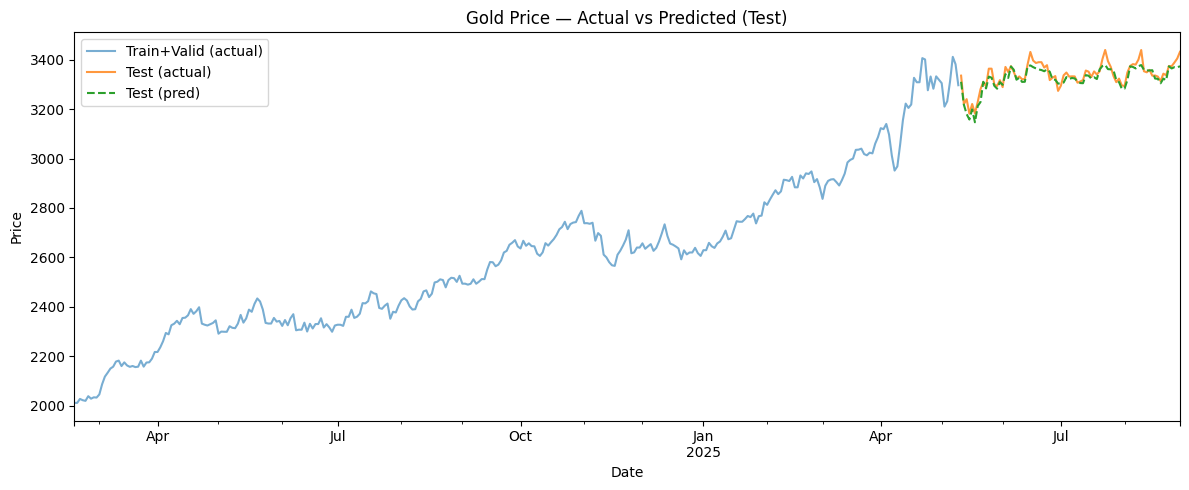

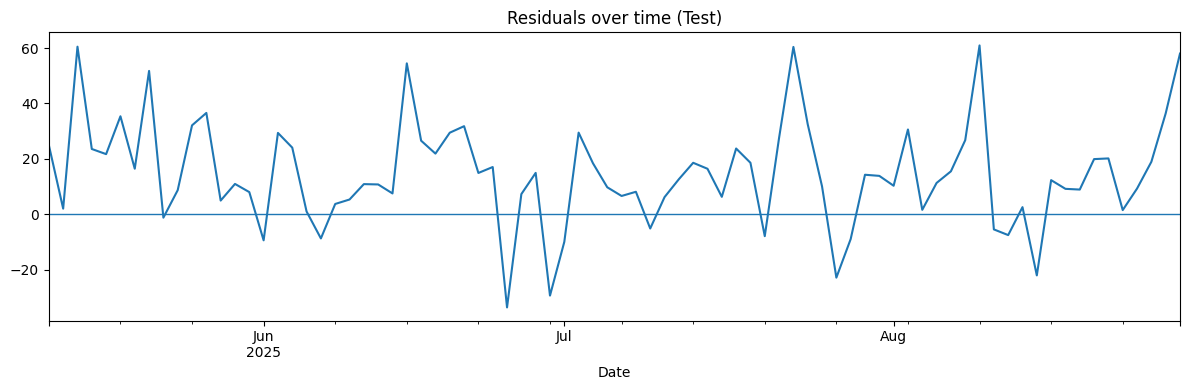

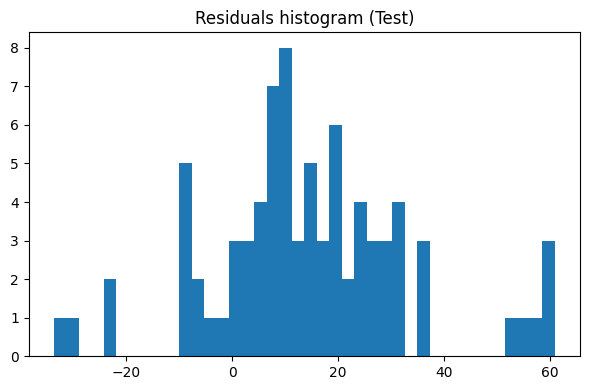

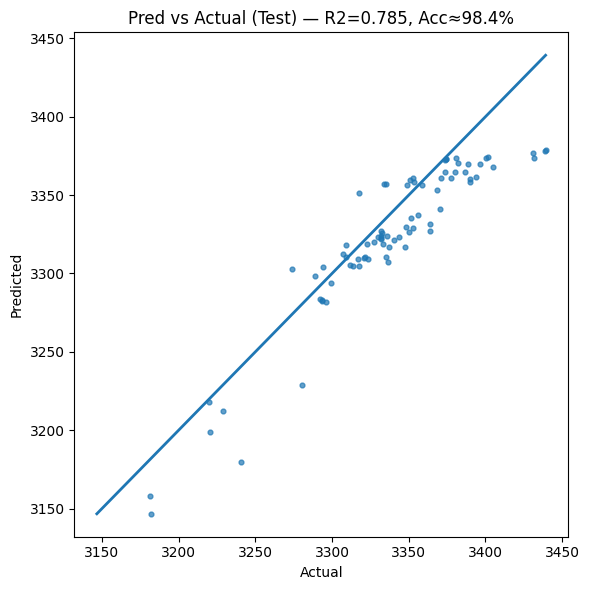

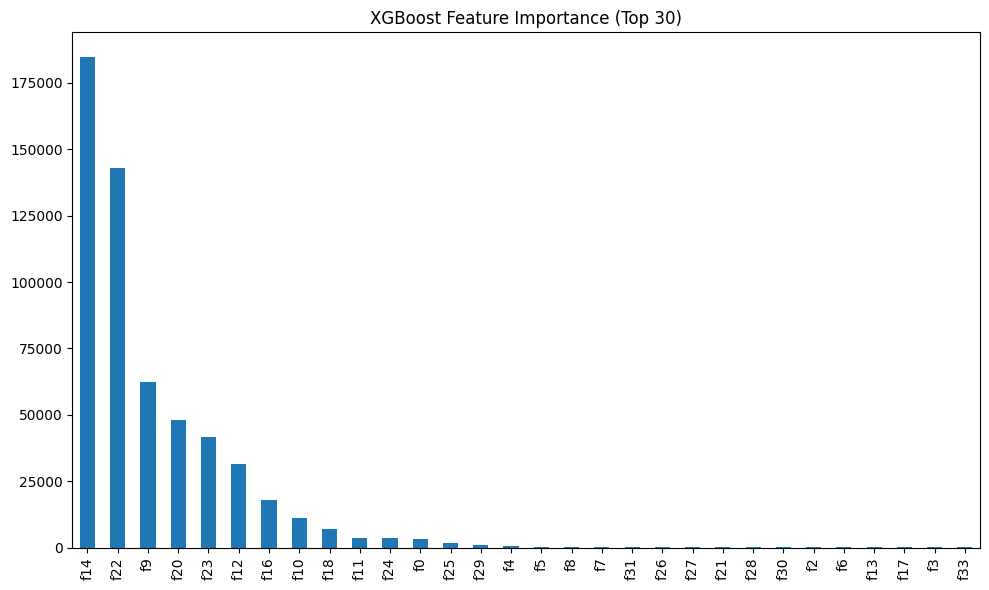

In [64]:
# --- make sure we have 1D aligned series ---
import numpy as np
import pandas as pd

# y_test -> Series 1D
y_test_s = y_test.iloc[:, 0].rename('actual') if isinstance(y_test, pd.DataFrame) else y_test
y_test_s = pd.Series(np.asarray(y_test_s).reshape(-1), index=y_test_s.index, name='actual').astype(float)

# pred_test -> Series 1D aligned to y_test.index
pred_1d = np.asarray(pred_test).reshape(-1)
if len(pred_1d) != len(y_test_s):
    raise ValueError(f"Length mismatch: y_test={len(y_test_s)} pred={len(pred_1d)}")
pred_s = pd.Series(pred_1d, index=y_test_s.index, name='pred').astype(float)

# 1) Actual vs Predicted (test range)
fig, ax = plt.subplots(figsize=(12,5))
# ถ้ามี y_trainval ให้ทำให้เป็น Series 1D เช่นกัน
y_trv_s = y_trainval.iloc[:,0] if isinstance(y_trainval, pd.DataFrame) else y_trainval
pd.Series(np.asarray(y_trv_s).reshape(-1), index=y_trv_s.index, name='Train+Valid').plot(
    ax=ax, label="Train+Valid (actual)", alpha=0.6
)
y_test_s.plot(ax=ax, label="Test (actual)", alpha=0.8)
pred_s.plot(ax=ax, linestyle='--', label="Test (pred)")
ax.set_title("Gold Price — Actual vs Predicted (Test)")
ax.set_ylabel("Price")
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "actual_vs_pred_test.png"))
plt.show()

# 2) Residuals over time & histogram
resid = (y_test_s - pred_s).astype(float)

fig, ax = plt.subplots(figsize=(12,4))
resid.plot(ax=ax)
ax.axhline(0, lw=1)
ax.set_title("Residuals over time (Test)")
fig.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "residuals_over_time.png"))
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(resid.dropna().values, bins=40)
ax.set_title("Residuals histogram (Test)")
fig.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "residuals_hist.png"))
plt.show()

# 3) Prediction vs Actual (scatter)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test_s.values, pred_s.values, s=12, alpha=0.7)
m = float(np.nanmin(np.r_[y_test_s.values, pred_s.values]))
M = float(np.nanmax(np.r_[y_test_s.values, pred_s.values]))
ax.plot([m, M], [m, M], lw=2)
ax.set_title(f"Pred vs Actual (Test) — R2={r2:.3f}, Acc≈{(100*(1-mape_val)):.1f}%")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
fig.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "pred_vs_actual_scatter.png"))
plt.show()

# 4) Feature importance (gain)
try:
    booster = pipe.named_steps['model']
    imp = booster.get_booster().get_score(importance_type="gain")
    imp_series = pd.Series(imp).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10,6))
    imp_series.head(30).plot(kind="bar", ax=ax)
    ax.set_title("XGBoost Feature Importance (Top 30)")
    fig.tight_layout()
    fig.savefig(os.path.join(ARTIFACT_DIR, "feature_importance.png"))
    plt.show()
except Exception as e:
    print("[WARN] Could not plot feature importance:", e)


## (Optional) SHAP for Interpretability

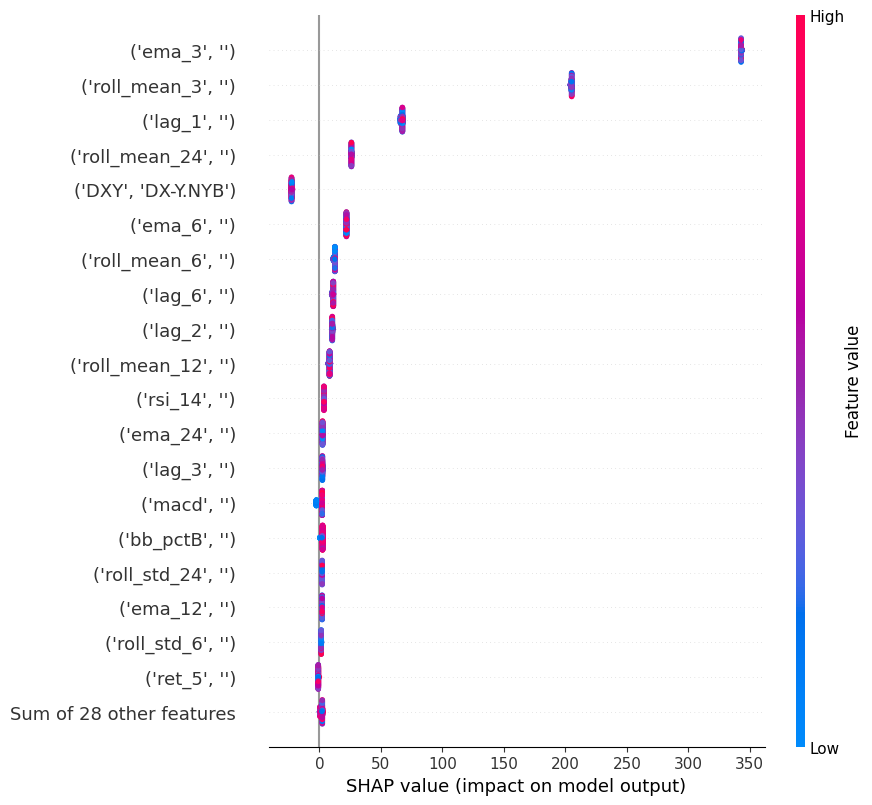

In [66]:

# This section can be heavy; run if you have shap installed.
try:
    import shap
    booster = pipe.named_steps["model"]
    # Build a small sample to keep it fast
    sample = X_trainval.sample(n=min(2000, len(X_trainval)), random_state=SEED)
    explainer = shap.Explainer(booster, feature_names=list(X_trainval.columns))
    shap_values = explainer(sample)
    shap.plots.beeswarm(shap_values, max_display=20, show=True)
except Exception as e:
    print("[WARN] SHAP plot skipped:", e)


## Summary & Acceptance Check

In [67]:

print("=== Final Metrics on Held-out Test ===")
display(pd.DataFrame([metrics]))

PASS = metrics["Accuracy(=100*(1-MAPE))%"] >= 90.0
print(f"\nAcceptance (Accuracy >= 90%): {'PASS ✅' if PASS else 'FAIL ❌'}")

print("\nArtifacts saved under:", os.path.abspath(ARTIFACT_DIR))
for f in sorted(os.listdir(ARTIFACT_DIR)):
    print(" -", f)


=== Final Metrics on Held-out Test ===


,MAE,RMSE,R2,MAPE,sMAPE,Accuracy(=100*(1-MAPE))%
0,18.843914,23.84701,0.785296,0.016278,0.01636,98.372243



Acceptance (Accuracy >= 90%): PASS ✅

Artifacts saved under: c:\othai\ML_LSDM\XG_Boost\artifacts
 - actual_vs_pred_test.png
 - feature_importance.png
 - forecast_6m.csv
 - forecast_6m.png
 - forecast_6m_pi.csv
 - pred_vs_actual_scatter.png
 - residuals_hist.png
 - residuals_over_time.png
 - test_predictions.csv
